In [2]:
import tensorflow as tf   ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plots
import sklearn ### machine learning library
import cv2 as cv ## image processing
import joblib ## load and import model
import os
import seaborn as sns ### visualizations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Resizing, Rescaling,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras import layers, regularizers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [3]:
train_dir = "images/seg_train"
val_dir = "images/seg_test"

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1./255)

In [5]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True)

val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 14028 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
conv_base = VGG16(
    weights= 'imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

In [8]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
conv_base.trainable = False

In [12]:
model = tf.keras.Sequential([
    conv_base,
    Flatten(),

    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(32,activation='relu'),
    Dense(6,activation='softmax')
])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,767,718 (60.15 MB)

 Trainable params: 1,053,030 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=0,
    mode='auto')

In [ ]:
%%time 
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=10,
                    validation_data=val_set,
                    validation_steps=val_set.samples//32,
                    callbacks = [es_callback,lr_callback])

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1797s 4s/step - accuracy: 0.7388 - loss: 1.2993 - val_accuracy: 0.8508 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 2/10
  1/438 ━━━━━━━━━━━━━━━━━━━━ 18:51 3s/step - accuracy: 0.8438 - loss: 0.5355

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 251s 568ms/step - accuracy: 0.8438 - loss: 0.5355 - val_accuracy: 0.8401 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1423s 3s/step - accuracy: 0.8287 - loss: 0.6333 - val_accuracy: 0.8491 - val_loss: 0.5752 - learning_rate: 0.0010
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 247s 559ms/step - accuracy: 0.9375 - loss: 0.4775 - val_accuracy: 0.8491 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 5/10
 95/438 ━━━━━━━━━━━━━━━━━━━━ 15:02 3s/step - accuracy: 0.8381 - loss: 0.5882

In [31]:
val_loss, val_accuracy = model.evaluate(val_set)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.7405 - loss: 0.9762
Validation Loss: 0.9649381041526794
Validation Accuracy: 0.7473834156990051


In [8]:
val_loss, val_accuracy = model.evaluate(val_set)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 930ms/step - accuracy: 0.7635 - loss: 0.9305
Validation Loss: 0.9649381637573242
Validation Accuracy: 0.7473834156990051


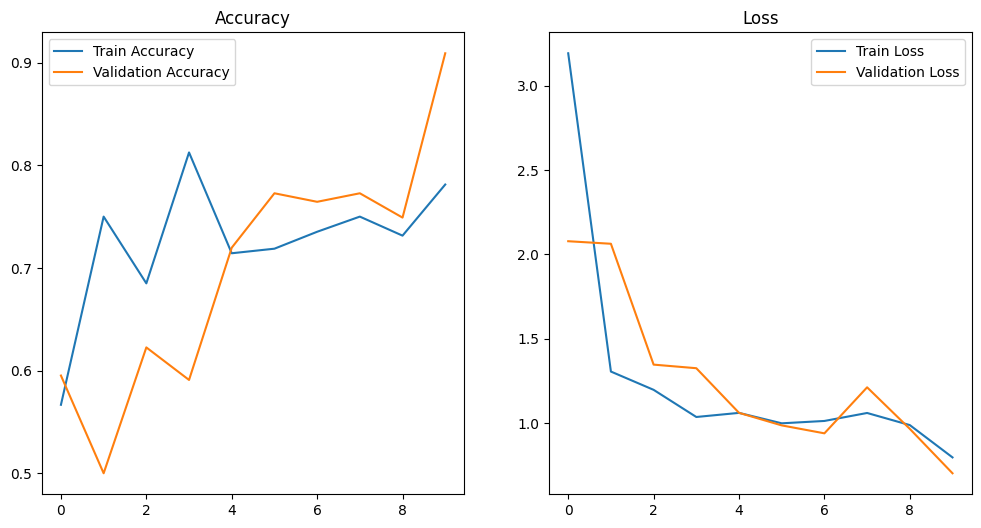

In [32]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [33]:
print("class indices : ",train_set.class_indices)

class indices :  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [3]:
from tensorflow.keras.preprocessing import image

def predict_img(img_path):
    img = image.load_img(img_path,target_size = (150,150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array,axis = 0)
    img_array /= 255.0

    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    class_labels =  {0: 'buildings',1: 'forest',2: 'glacier',3: 'mountain',4: 'sea',5: 'street'}

    plt.imshow(img)
    plt.title(f'Predicted: {class_labels[class_idx]}')
    plt.show()

    print(f'Predicted class: {class_labels[class_idx]} with probability: {pred[0][class_idx]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


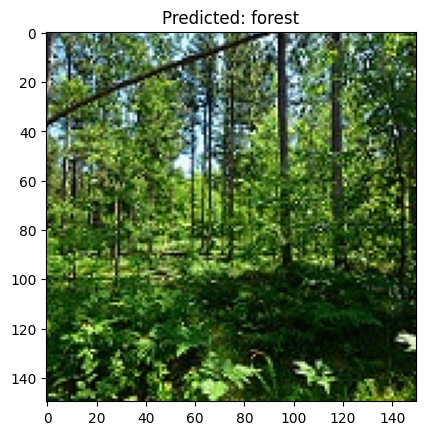

Predicted class: forest with probability: 0.9988223910331726


In [38]:
predict_img("images/seg_pred/64.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


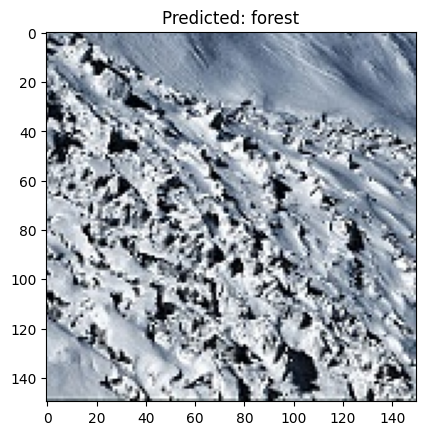

Predicted class: forest with probability: 0.5411715507507324


In [40]:
predict_img("images/seg_pred/176.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


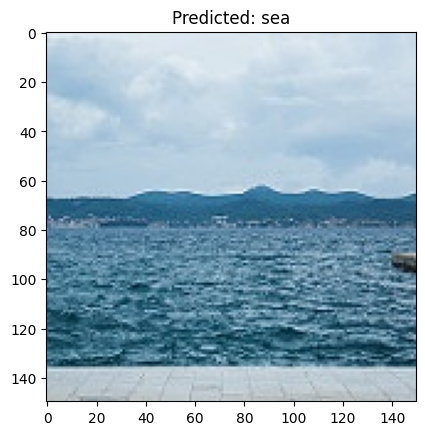

Predicted class: sea with probability: 0.9132236838340759


In [41]:
predict_img("images/seg_pred/233.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


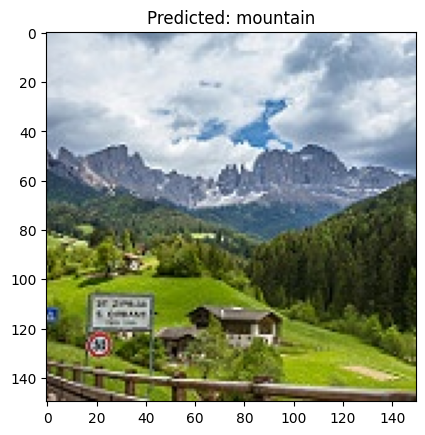

Predicted class: mountain with probability: 0.8514845967292786


In [45]:
predict_img("images/seg_pred/1222.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


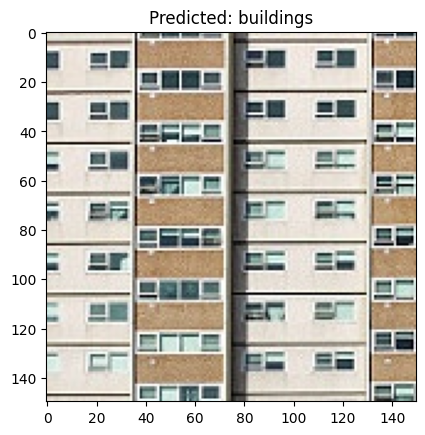

Predicted class: buildings with probability: 0.9871565103530884


In [46]:
predict_img("images/seg_pred/222.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


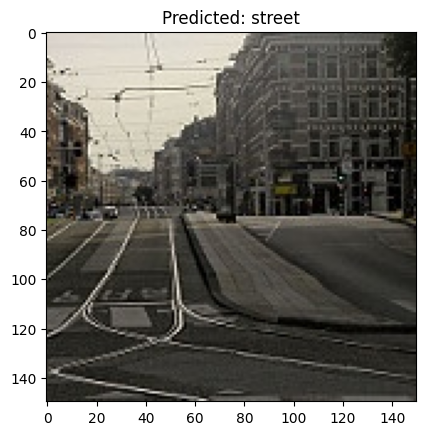

Predicted class: street with probability: 0.4551607072353363


In [47]:
predict_img("images/seg_pred/689.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


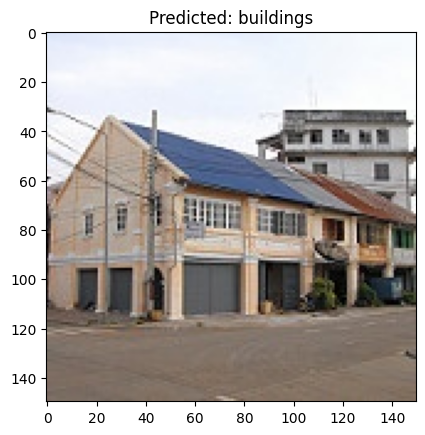

Predicted class: buildings with probability: 0.6483747959136963


In [48]:
predict_img("images/seg_pred/1206.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


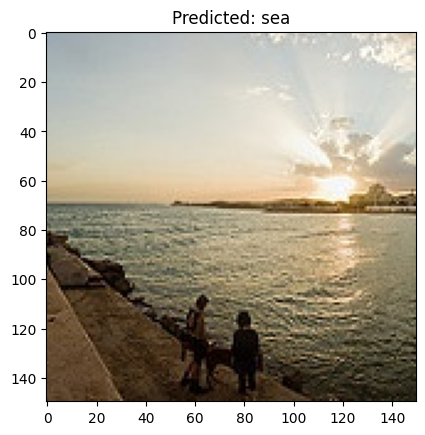

Predicted class: sea with probability: 0.7158541679382324


In [49]:
predict_img("images/seg_pred/274.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


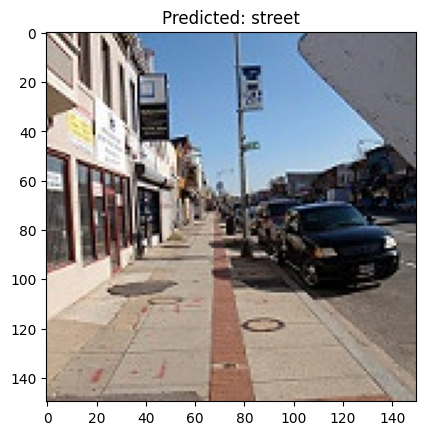

Predicted class: street with probability: 0.8254884481430054


In [50]:
predict_img("images/seg_pred/69.jpg")

In [55]:
import joblib

joblib.dump(model,'intel_image_classification_model.pkl')

['intel_image_classification_model.pkl']

In [6]:
import joblib

model = joblib.load('intel_image_classification_model.pkl')

In [7]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,922,292 (121.77 MB)

 Trainable params: 10,640,742 (40.59 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 21,281,486 (81.18 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


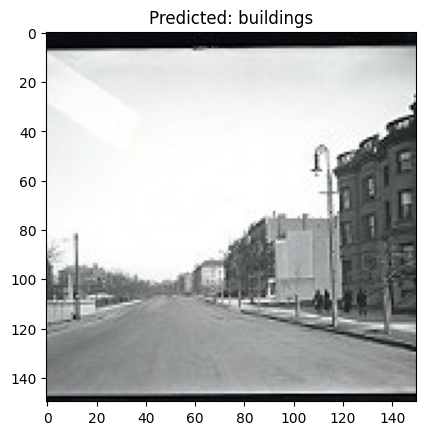

Predicted class: buildings with probability: 0.4752797782421112


In [26]:
predict_img("images/seg_pred/169.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


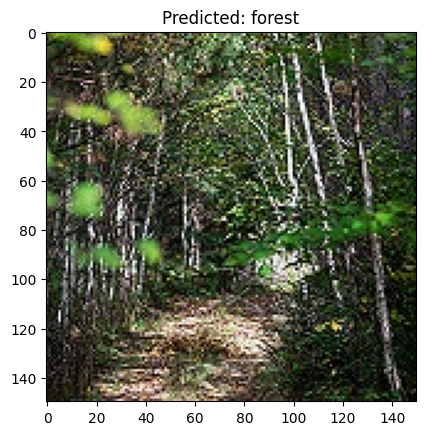

Predicted class: forest with probability: 0.9365399479866028


In [27]:
predict_img("images/seg_pred/172.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


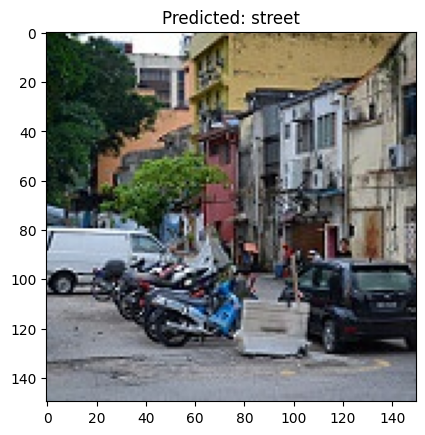

Predicted class: street with probability: 0.5900871753692627


In [25]:
predict_img("images/seg_pred/17482.jpg")